In [1]:
import os
import random
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import pydot
import pydotplus
import graphviz
from sklearn import metrics
from keras import regularizers
from keras.layers import Dense, Activation, Input, Dropout, BatchNormalization
from keras.models import Sequential
from keras_tqdm import TQDMNotebookCallback as ktqdm
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix

Using TensorFlow backend.


## Reproducibility

In [2]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)
tf.set_random_seed(42)

## Creation of uniform distribution of predecessors

In [3]:
step = 50
size = 10000
n = step * size
width = np.ceil(np.log2(n)).astype(int)
predecessors = np.arange(0, n, step)
predecessors = np.array([
    (predecessors[i]) for i in range(size)
]).astype(int)
predecessors, predecessors.shape

(array([     0,     50,    100, ..., 499850, 499900, 499950]), (10000,))

In [4]:
cumulative_predecessors = np.array([(((i / size))) for i in range(size)])
#cumulative_predecessors = np.array([(((i / size) * 2) - 1) for i in range(size)])

cumulative_predecessors, cumulative_predecessors.size

(array([0.000e+00, 1.000e-04, 2.000e-04, ..., 9.997e-01, 9.998e-01,
        9.999e-01]), 10000)

## Bit conversion in digits of predecessors

In [5]:
predecessors = np.array([
    list(np.binary_repr(i, width)) for i in np.arange(0, n, step)
]).astype(int)
np.set_printoptions(threshold=100)
predecessors, predecessors.shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 1, 0],
        [1, 1, 1, ..., 1, 0, 0],
        [1, 1, 1, ..., 1, 1, 0]]), (10000, 19))

## Create training + testing set

In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    predecessors, 
    cumulative_predecessors, 
    test_size=0.25, 
    random_state=42)

In [7]:
x_train.shape, y_train.shape

((7500, 19), (7500,))

In [8]:
x_test.shape, y_test.shape

((2500, 19), (2500,))

## Network Metrics

In [9]:
def plot_history_graph(history, index, label):
    """Plot the graph for the given history metrics."""
    plt.plot(history.history[index], label='Training %s = %0.6f' % (label, history.history[index][-1]))
    plt.plot(history.history['val_%s'%index] , label='Testing %s = %0.6f' % (label, history.history['val_%s'%index][-1]))
    plt.title('Model %s'%label, fontsize=15)
    plt.ylabel(label)
    plt.xlabel('epoch')
    plt.legend(loc='lower right')
    plt.figure(figsize=(40,20))

## Defining custom sigmoid function

In [10]:
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

def custom_activation(x):
    return (K.sigmoid(x))

def custom_sigmoid(x, beta):
    return (1 / (1 + math.exp(-beta * x)))


## Define function to build the model

In [11]:
from keras import metrics, optimizers

#sgd = optimizers.SGD(lr=0.02, momentum=0.0, decay=0.0, nesterov= False)

def build_model(neurons):
    """ Return keras network model """
    model = Sequential()
    model.add(Dense(int(neurons / 2), input_dim=neurons, name="Input_dense_layer", activation=custom_activation))
    #model.add(Activation("sigmoid", name="Input_Sigmoid"))
    #model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(1, name="Output_dense_layer", activation="sigmoid"))
    #model.add(Activation("sigmoid", name="Output_Sigmoid"))
    #model.add(BatchNormalization())
    model.compile(
        loss='mean_squared_error', 
        optimizer='sgd', 
        metrics=['mean_absolute_error'])

    return model

## Construction of the model

In [12]:
from keras.utils import plot_model

model = build_model(width)
model.summary()
plot_model(model, to_file="net_model.png")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_dense_layer (Dense)    (None, 9)                 180       
_________________________________________________________________
batch_normalization_1 (Batch (None, 9)                 36        
_________________________________________________________________
Output_dense_layer (Dense)   (None, 1)                 10        
Total params: 226
Trainable params: 208
Non-trainable params: 18
_________________________________________________________________


In [13]:
history = model.fit(
    x_train, 
    y_train,
    epochs=50,
    shuffle=True,
    batch_size=256,
    verbose=0,
    callbacks=[ktqdm(metric_format="{name}: {value:e}")],
    validation_data=(x_test, y_test)
)
#1) Nota, con una batch size minore di 64 le cose sembrano migliorare.
#Un numero di epoche pari a 50 sembra aiutare
#La seconda batch normalization non pare essere di aiuto, anzi! I risultati peggiorano
#Togliendo la prima batch normalization i risultati peggiorano ulteriormente
#Eliminare il dropout funziona! I risultati sono vicini a quelli sperati!
#Aumentare le epoche sopra il 50 non pare aiutare

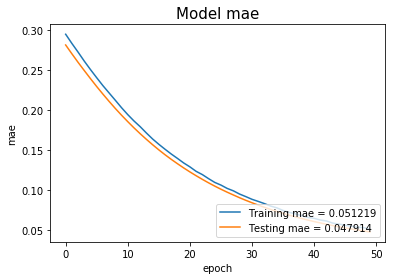

<Figure size 2880x1440 with 0 Axes>

In [14]:
plot_history_graph(history, 'mean_absolute_error', 'mae')

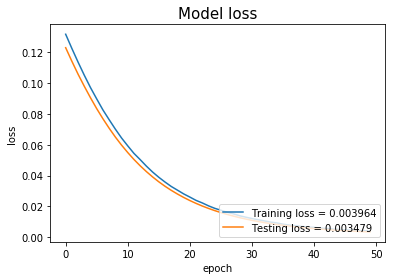

<Figure size 2880x1440 with 0 Axes>

In [15]:
plot_history_graph(history, 'loss', 'loss')

In [16]:
def prediction(num, width, model):
    bin = np.array([list(np.binary_repr(num, width))])
    print(bin)
    print(model.predict(bin))

(prediction(int(50 * 10000), width, model)), (prediction(int(1), width, model)), width

[['1' '1' '1' '1' '0' '1' '0' '0' '0' '0' '1' '0' '0' '1' '0' '0' '0' '0'
  '0']]
[[0.9121199]]
[['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
  '1']]
[[0.04993232]]


(None, None, 19)

In [17]:
#NOTA:
#FARSI UN LOG CON TUTTI GLI ESPERIMENTI PERCHÈ SARANNO MATERIALE DI TESI

#Specificare funzione di attivazione custom sigmoide con beta fissato
#Sigmoide = 1 / (1 + e ^ -beta * x)
#Derivata di sigmoide = beta
#Asintoti = 0, 1
#Beta elevato = slope più ripido
#Per beta diversi fare grafici diversi
#Guardare se con tali beta le predizioni migliorano

#Potrebbe essere che beta fosse troppo basso rendendo incapace la rete di raggiungere 0 ed 1

#Partire con beta minori di 1 e beta maggiori 1

#Modificare i learning rates
#Modificare neuroni hidden per farsi idea di "ottimale"


#NB: SE NULLA FUNZIONA PROVA QUA
#Se funziona male provare un primo strato nascosto con relu ed un secondo con sigmoide

In [18]:
#Modificato il learning rate, dallo standard 0.01 a 0.02. I risultati PAIONO lievemente più accettabili.
#Proviamo con 0.05

In [19]:
#Utilizzare un lr di 0.05 non sembra migliorare troppo le cose. Proviamo con 0.1 e 0.5

#0.1 pare peggiorare
#0.5 peggiora assolutamente le cose

In [20]:
#I valori di default del learning rate decay peggiorano solo la situazione nella predizione.
#Meglio mantenere un valore oscillante tra 0.01 e 0.02